In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download dhanushnarayananr/credit-card-fraud

Dataset URL: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud
License(s): CC0-1.0
 90% 26.0M/28.9M [00:02<00:00, 16.2MB/s]
100% 28.9M/28.9M [00:02<00:00, 11.3MB/s]


In [3]:
import zipfile
zip_ref =  zipfile.ZipFile(r'/content/credit-card-fraud.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Introduction:
Credit card fraud is a significant and growing problem in the financial industry, causing billions of dollars in losses annually. Fraudulent transactions can result in financial damage for both consumers and businesses, eroding trust in digital payment systems. As the volume of online transactions increases, the need for robust fraud detection systems becomes more critical. Traditional rule-based systems often fall short due to the evolving nature of fraud tactics, which necessitates the use of advanced machine learning techniques to detect anomalies effectively. This project aims to build a predictive model for detecting fraudulent credit card transactions by leveraging historical data and applying machine learning algorithms.

### Import Libraries:

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Hepling Funcions:

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support,roc_curve, auc, accuracy_score

# Model Evaluation
def model_evaluation(yt, yp):
    results = {}
    results['accuracy'] = accuracy_score(yt, yp)

    precision, recall, fscore, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    results['precision'] = precision
    results['recall'] = recall
    results['fscore'] = fscore

    metrics = list(results.keys())
    values = list(results.values())

    ax = sns.barplot(x = metrics, y = values, palette = 'viridis')
    plt.title('Model Evaluation Metrics')
    plt.ylim(0,1)
    plt.ylabel('Value')

    for i, v in enumerate(values):
        plt.text(i, v/2, f'{v: 0.2f}', ha = 'center', va = 'center', color = 'white',
                fontsize = 12)
    plt.show()

# Classification Report
def class_report(yt, yp):
    cr = pd.DataFrame(classification_report(yt, yp, output_dict = True))
    return cr.T.style.background_gradient(cmap = 'Blues', axis = 0)

# Confusion Matrix
def conf_matrix(yt, yp):
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot = True, linecolor = 'black', fmt = '0.2f', cmap = 'Blues',
               linewidths = 0.01)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

def plot_roc(yt, yp):
    fpr, tpr, thr = roc_curve(yt, yp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, color = 'darkorange', lw=2,
            label = f"ROC_CURVE (Area = {roc_auc : 0.3f})")
    plt.plot([0.0, 1.0], [0.0, 1.0], lw=2, color = 'navy', linestyle = '--')
    plt.xlim([-0.01, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

### Exploratory Data Analysis:

In [6]:
df = pd.read_csv(r'/content/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [7]:
# Finding the dataset infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [8]:
# Finidng if null values exists
df.isnull().sum()

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


In [9]:
# Defininf discriptive statistics
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Finding any duplicated value
df.duplicated().sum()

0

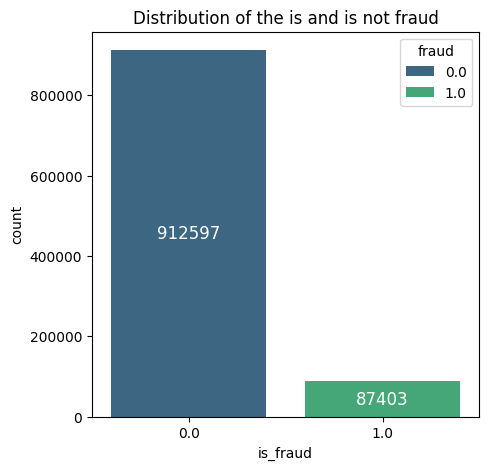

In [11]:
# Distribution of Credit Card Fraud col
plt.figure(figsize = (5,5))

ax = sns.countplot(x = 'fraud', data = df, hue = 'fraud', palette = 'viridis')
plt.title('Distribution of the is and is not fraud')
plt.xlabel('is_fraud')

for i, v in enumerate(list(df['fraud'].value_counts())):
  plt.text(i, v/2 , f'{v}', ha = 'center', va = 'center', color = 'white', fontsize = 12)
plt.show()

Most of time it shows credit card fraud is not that much frequent. However, as the it is sensitive matter so times fraud happened.

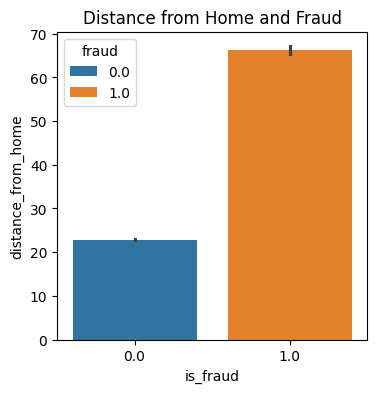

In [12]:
# Home distance and fraud occurence
plt.figure(figsize = (4,4))
sns.barplot(y = 'distance_from_home', x = 'fraud', data = df, hue = 'fraud')
plt.title('Distance from Home and Fraud')
plt.xlabel('is_fraud')
plt.show()

It tells that most of the frauds occured when there was a large distance from transaction place and home. So it says there are more chances that there is fraud when the distance between home and transaction place is more.

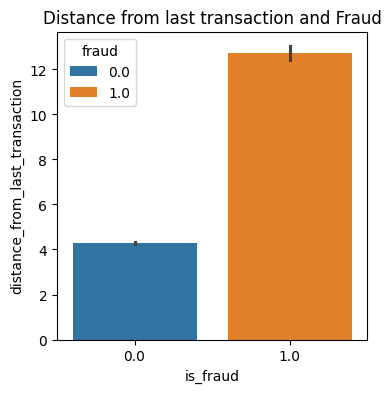

In [13]:
# Last transaction distance and fraud
plt.figure(figsize = (4,4))
sns.barplot(y = 'distance_from_last_transaction', x = 'fraud', data = df, hue = 'fraud')
plt.title('Distance from last transaction and Fraud')
plt.xlabel('is_fraud')
plt.show()

So it also says that there are more occurence of the frauds when users and last transaction happened are at a large distance.

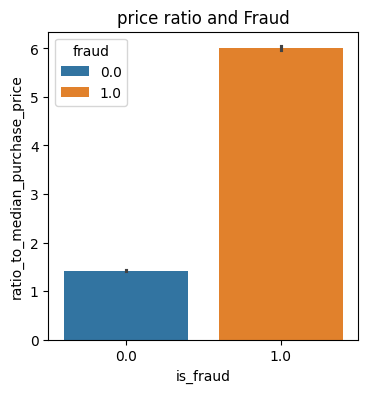

In [14]:
# Ratio of price and median price of transaction and fraud
plt.figure(figsize = (4,4))
sns.barplot(y = 'ratio_to_median_purchase_price', x = 'fraud', data = df, hue = 'fraud')
plt.title('price ratio and Fraud')
plt.xlabel('is_fraud')
plt.show()

We have price ration of (purchased price / median price). So when this ratio is greater than 1 then it says that price is more than median price. So it says that most of the prices that are more than median prices have more occurence of frauds.

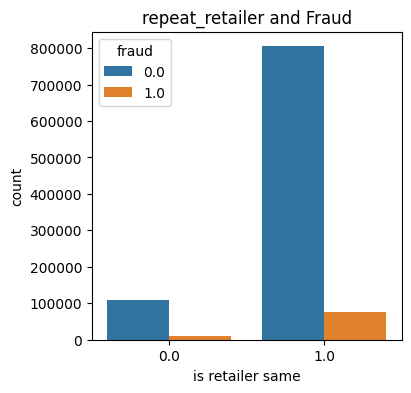

In [15]:
# repeat_retailer and fraud
plt.figure(figsize = (4,4))
sns.countplot(x = 'repeat_retailer', data = df, hue = 'fraud')
plt.title('repeat_retailer and Fraud')
plt.xlabel('is retailer same')
plt.show()

So it says that more cases of fraud occured when the retailer is same.

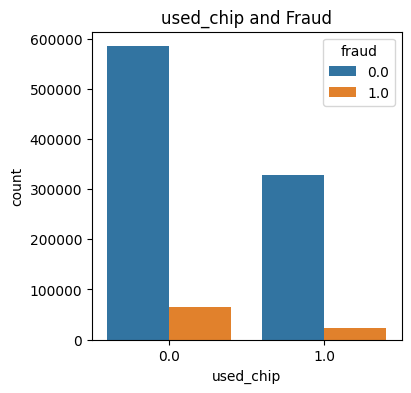

In [16]:
# used_chip and fraud
plt.figure(figsize = (4,4))
sns.countplot(x = 'used_chip', data = df, hue = 'fraud')
plt.title('used_chip and Fraud')
plt.xlabel('used_chip')
plt.show()

When the chip is used means that credit card then occurence of the fraud are less likely to get occured.

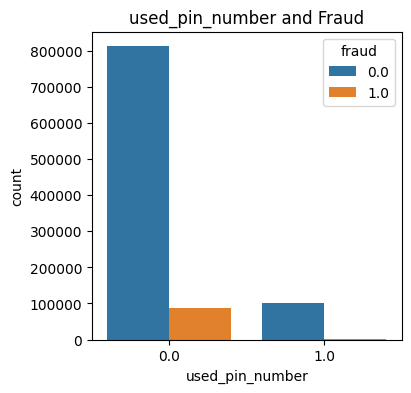

In [17]:
# used_pin_number and fraud
plt.figure(figsize = (4,4))
sns.countplot(x = 'used_pin_number', data = df, hue = 'fraud')
plt.title('used_pin_number and Fraud')
plt.xlabel('used_pin_number')
plt.show()

When used pin number during transaction then credit card fraud occured are less.

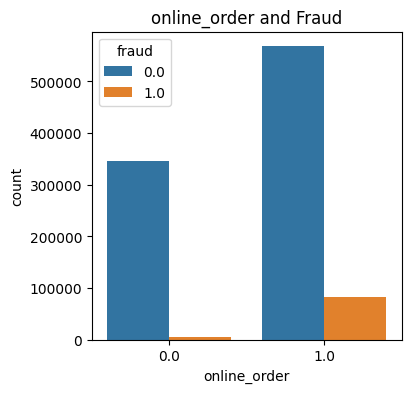

In [18]:
# online_order and fraud
plt.figure(figsize = (4,4))
sns.countplot(x = 'online_order', data = df, hue = 'fraud')
plt.title('online_order and Fraud')
plt.xlabel('online_order')
plt.show()

As per the figure when the transaction is online then number of frauds occured are more than physical transaction.

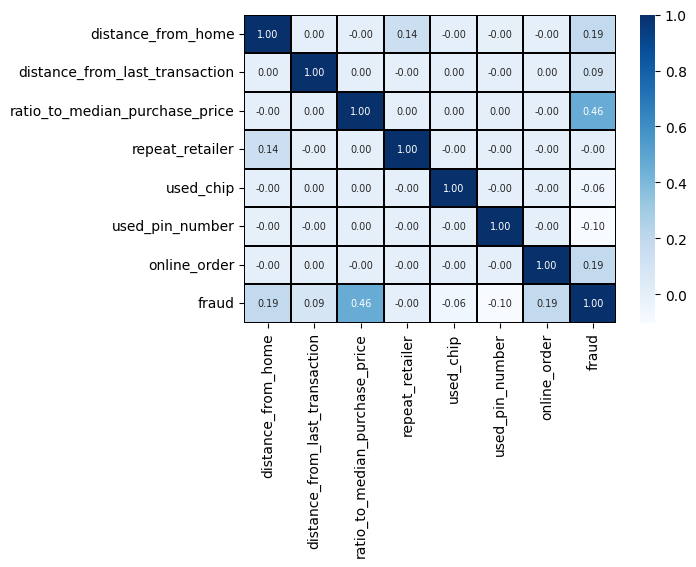

In [19]:
# Correlation Matrix:
plt.figure(figsize = (6,4))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap = 'Blues', linewidths = 0.01, linecolor = 'black',
           fmt = '0.2f', annot_kws = {'fontsize' : 7})
plt.xticks(fontsize = 10, rotation = 90)
plt.yticks(fontsize = 10, rotation = 0)
plt.show()

The correlation of repeat_retailer has high correation with the fraud. That means it says there exists exists positive relation with the fraud and repeat_retailer. However, with other features fraud has little relation.

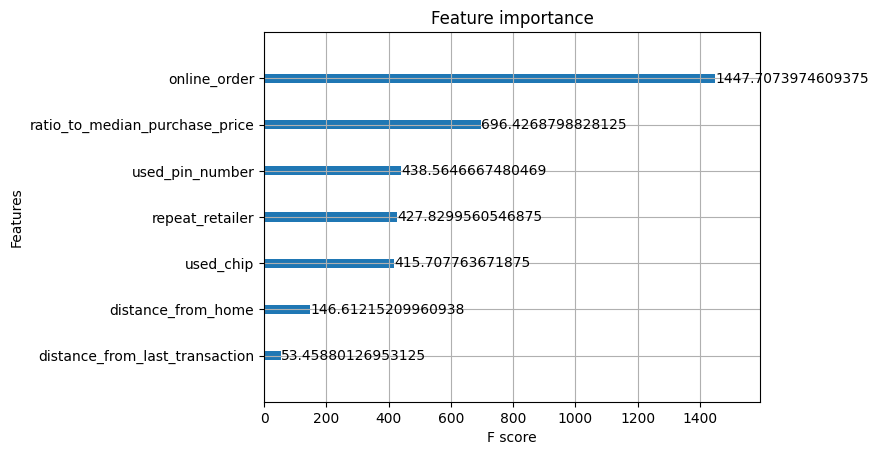

In [20]:
# Finding important variables
import xgboost as xgb
from xgboost import plot_importance

# Assuming you have your data ready in X (features) and y (target)
model = xgb.XGBClassifier()  # or XGBRegressor for regression tasks
model.fit(df.drop('fraud', axis = 1), df['fraud'])

# Plot feature importance
plot_importance(model, importance_type='gain')  # You can choose 'gain', 'weight', or 'cover'
plt.show()

Do not drop feature when score > 0.01 or 1. So we can see that all the features are greter than 1 and provide information that features can increase the model accuracy.

### Data Preprocessing:

In [21]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['fraud'], axis = 1), df['fraud'], test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)

(800000, 7)
(800000,)


In [22]:
# Scaling to z-scores
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

X_train_scaled: (800000, 7)
X_test_scaled: (200000, 7)


### XGBOOST Algorithm:

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

params_dist = {
    'n_estimators' : [20 * n for n in range(1,21)],
    'max_depth' : [3,4,5],
    'learning_rate' : [0.1, 0.01, 0.001, 0.0001]
}

random_search = RandomizedSearchCV(estimator = xgb, param_distributions = params_dist,
                                  cv=5, scoring = 'accuracy', n_jobs = -1, n_iter = 10)
random_search.fit(X_train_scaled, y_train.values.ravel())

print(f"Best Parameters : {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Best Parameters : {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.9982712499999999


In [28]:
y_pred = random_search.predict(X_test_scaled)

# Classification Report
class_report(y_test, y_pred)

,precision,recall,f1-score,support
0.0,0.998976,0.999063,0.999020,182557.000000
1.0,0.990188,0.989279,0.989733,17443.000000
accuracy,0.998210,0.998210,0.998210,0.998210
macro avg,0.994582,0.994171,0.994376,200000.000000
weighted avg,0.998209,0.998210,0.998210,200000.000000


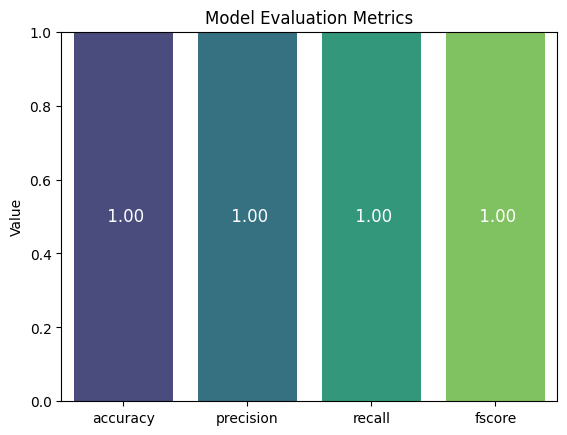

In [29]:
# Model Evaluation
model_evaluation(y_test, y_pred)

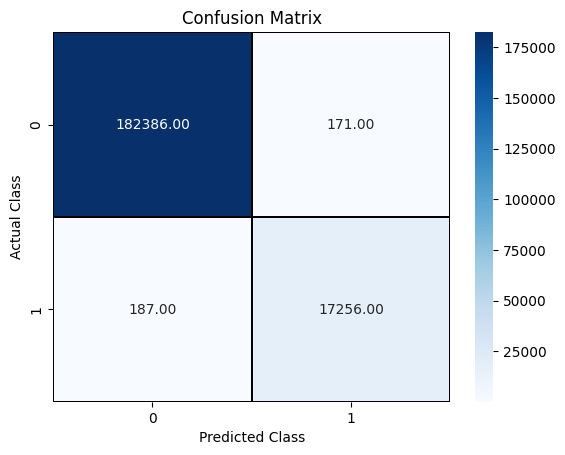

In [30]:
# Confussion matrix
conf_matrix(y_test, y_pred)

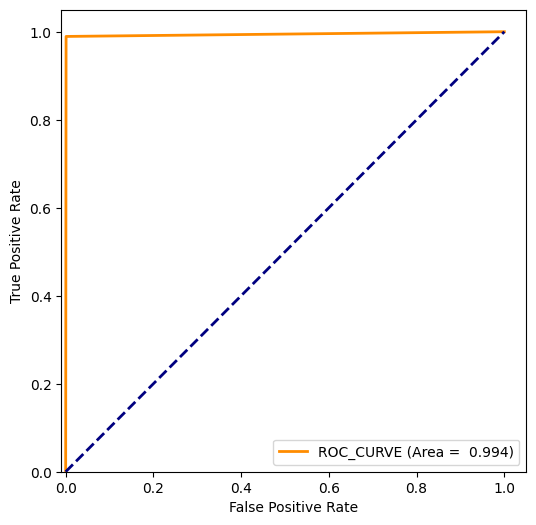

In [31]:
# ROC CURVE
plot_roc(y_test, y_pred)

We have used the credit fraud dataset from kaggle to find credit fraud. We used XGBOOST model which worked well on the test set with AUC score of 0.99.

### Conclusion:
In this project, we successfully developed a credit card fraud detection system using the XGBoost algorithm, which demonstrated high effectiveness in identifying fraudulent transactions. XGBoost's ability to handle large datasets and capture complex patterns made it an ideal choice for this task. By tuning hyperparameters and leveraging the algorithm's efficiency, the model achieved strong performance metrics, indicating its capability to distinguish between legitimate and fraudulent transactions accurately.

The results suggest that XGBoost can be a powerful tool in detecting fraud, offering both speed and accuracy in a real-world setting. However, to further improve the model’s adaptability, future work could explore additional features or real-time data analysis to enhance prediction accuracy. Overall, this model provides a solid foundation for implementing an automated fraud detection system in the financial industry, helping reduce losses and improve transaction security.